While my "2020-07-10-aws" notebook is still running, I'm just going to plot some results in matplotlib here locally. I don't want to interrupt the sagemaker notebook instance memory. 

I am impressed that it did not crash and that somehow AWS did not kill it.

`2020-07-10 15:22:40Z, [0] Start xgb.train` Started first xgb train
`2020-07-11 14:02:07Z, [266] Start xgb.train` still going

Based on the combinations beingtested , `3*3*3*3*3*6 = 1458` there's some more waiting to do for sure. Going to check which models take longer perhaps

In [24]:
import pandas as pd
import datetime; import pytz
import matplotlib.pyplot as plt
from joblib import dump, load
import joblib
import os
from functools import reduce
import fresh.s3utils as fs3
from importlib import reload
import json
import fresh.plot as fp
import fresh.vanilla_utils as fvu



In [29]:
# os.environ['MY_SAGEMAKER_S3_BUCKET'] = ''  # storing this in my somevars.sh NOTE
# os.environ['MY_ACCESS_KEY_ID'] = ''
# os.environ['MY_SECRET_ACCESS_KEY'] = ''

mybucket = os.getenv('MY_SAGEMAKER_S3_BUCKET')
s3uri = (f's3://{mybucket}/'
         'bikelearn/artifacts/2020-07-10T135910Z/'
         '2020-07-11T143012Z_results_vec.json')
bucket, s3fn = fs3.s3uri_to_parts(s3uri)

results_vec = json.loads(fs3.read_s3_file(bucket, s3fn))
results_vec

[{'max_depth': 3,
  'learning_rate': 0.01,
  'objective': 'multi:softprob',
  'num_class': 54,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 0.1,
  'colsample_bynode': 1,
  'colsample_bytree': 0.1,
  'gamma': 0,
  'max_delta_step': 0,
  'min_child_weight': 1,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': 42,
  'subsample': 0.1,
  'verbosity': 0,
  'acc': 0.050964174262760016,
  'balanced_acc': 0.03684609209838398,
  'logloss': 3.9766314117097132,
  'walltime': 22.023615,
  'karea': 0.6426400363389939,
  'i': 0,
  'num_round': 10},
 {'max_depth': 3,
  'learning_rate': 0.01,
  'objective': 'multi:softprob',
  'num_class': 54,
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 0.1,
  'colsample_bynode': 1,
  'colsample_bytree': 0.1,
  'gamma': 0,
  'max_delta_step': 0,
  'min_child_weight': 1,
  'random_state': 0,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
  'seed': 42,
  'subsample': 0.

In [30]:
df = pd.DataFrame.from_records(results_vec)

Throwing the `compare_tuning` function from the earlier notebook   [2020-07-09-aws](https://github.com/namoopsoo/learn-citibike/blob/2020-revisit/notes/2020-07-09-aws.md) , and putting into a utility for easier use.. 

In [56]:
# ignore 
# 'base_score': 0.5,
# 'objective': 'multi:softprob',
# 'num_class': 54,
# 'booster': 'gbtree',
# 'gamma': 0,
# 'max_delta_step': 0,
# 'min_child_weight': 1,
# 'reg_alpha': 0,
# 'reg_lambda': 1,
# 'scale_pos_weight': 1,

print(df.shape)

keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
#df2 = df[reduce(lambda x, y: x&y, 
#        [(df[col] == val) for (col, val) in keep_fixed.items()])]
#df2.iloc[0]

# metric_cols = ['acc', 'balanced_acc', 'karea', 'logloss', 'walltime']


(268, 26)


In [70]:
metric_cols = ['logloss','acc', 'balanced_acc', 'karea']
hyperparameters = list(keep_fixed.keys())
print(metric_cols + hyperparameters)

['logloss', 'acc', 'balanced_acc', 'karea', 'max_depth', 'learning_rate', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'subsample', 'num_round']


In [49]:
reload(fp)

<module 'fresh.plot' from '/opt/program/fresh/plot.py'>

#### Quick look at subsample

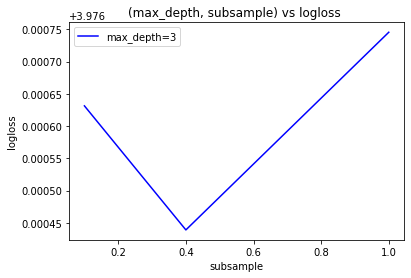

In [50]:
keep_fixed = {
# 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
# 'subsample': 0.1,
 'num_round': 10,
        }
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1='max_depth', 
             feature_col_2='subsample', 
             metric_col='logloss',
             keep_fixed=keep_fixed)

#### looking at num_round fundamentally 
- Seeing below that we're doing best at num_round=100 for the test set logloss, so that makes me think...
- => I should increase that num_round more since it is not plateauing yet here.. 

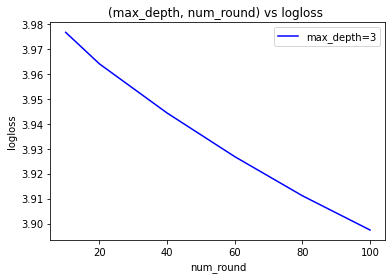

In [59]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'max_depth', 'num_round', 'logloss'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### walltime
- this one is kind of obvious, but good to see
- indeed, walltime looks pretty linear per num_rounds as expected 

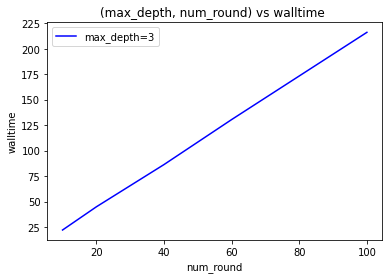

In [60]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'max_depth', 'num_round', 'walltime'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### learning rate and walltime
- hmm this actually I did not expect, somehow the `learning_rate=0.1` was taking longer than `learning_rate=0.01` , but also only at `num_round=100` . odd..
- => also somewhat obvious but should really have been tracking these metrics on my `watchlist` so I dont need to make `num_round` as a hyper parameter, to make this whole exercise probably `6x` faster.. anyways. 

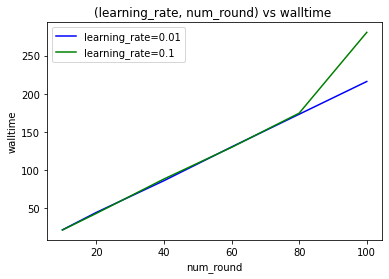

In [61]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'learning_rate', 'num_round', 'walltime'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### also learning rate vs acc? 
Oh wow, at least within these parameters, `learning_rate` is better at `0.1`

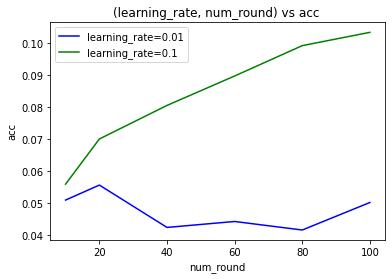

In [62]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'learning_rate', 'num_round', 'acc'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

In [71]:
df[metric_cols + hyperparameters].sort_values(by='logloss')

,logloss,acc,balanced_acc,karea,max_depth,learning_rate,colsample_bylevel,colsample_bynode,colsample_bytree,subsample,num_round
215,3.459240,0.121980,0.104280,0.756433,3,0.10,1.0,1,1.0,0.1,100
197,3.472623,0.120880,0.102801,0.754676,3,0.10,1.0,1,0.5,0.1,100
214,3.474821,0.121639,0.104054,0.753534,3,0.10,1.0,1,1.0,0.1,80
251,3.476552,0.122018,0.103783,0.753375,3,0.10,1.0,1,0.5,0.4,100
209,3.480950,0.119874,0.101660,0.753358,3,0.10,0.2,1,1.0,0.1,100
...,...,...,...,...,...,...,...,...,...,...,...
60,3.976439,0.051989,0.038299,0.643213,3,0.01,0.2,1,0.1,0.4,10
6,3.976631,0.050964,0.036846,0.642640,3,0.01,0.2,1,0.1,0.1,10
0,3.976631,0.050964,0.036846,0.642640,3,0.01,0.1,1,0.1,0.1,10
114,3.976746,0.039601,0.024028,0.640441,3,0.01,0.2,1,0.1,1.0,10


#### look at subsample w/ different rounds..
- Wow this is super weird... maybe it is about the other parameters .

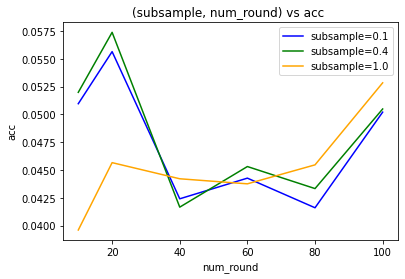

In [72]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'subsample', 'num_round', 'acc'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### hmm colsample_bylevel
- so Reducing from `colsample_bylevel=1.0` here now showing much benefits 

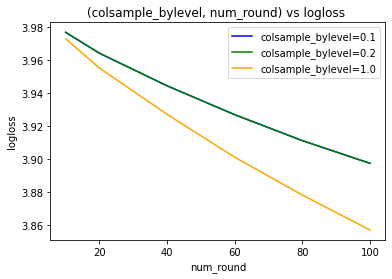

In [77]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 100,
        }
col1, col2, metric_col = 'colsample_bylevel', 'num_round', 'logloss'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### colsample_bynode?
ok not enough data yet


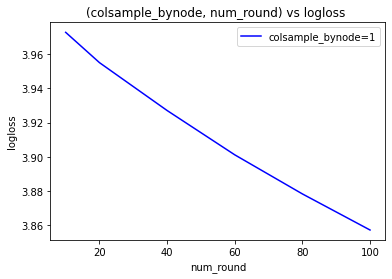

In [82]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 100,
        }
col1, col2, metric_col = 'colsample_bynode', 'num_round', 'logloss'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

#### karea
- One of the cool things I added here recently is a new metric indicating how well are the multi-class predictions ranked. 
- If the correct answer is in the top 5 class predictions, that's great, but maybe instead of a binary yes or no comparing two models, we can say which model get's there faster.
- Going to check correlation w/ the other metrics now... 
- Maybe it is another way of saying, given all of the available classes, how close to `k=1` are the ranked probabilities.. 

In [84]:
df[metric_cols].corr()

,logloss,acc,balanced_acc,karea
logloss,1.000000,-0.529091,-0.533594,-0.719519
acc,-0.529091,1.000000,0.990071,0.928016
balanced_acc,-0.533594,0.990071,1.000000,0.936010
karea,-0.719519,0.928016,0.936010,1.000000


- ok so looking above, definitely expected `acc` and `karea` to be highly correlated, so this just showing things are working properly.
- the low correlation between logloss and the accuracy family of metrics I think indicates that logloss is kind of erratic with so many classes. 
- In this project, the xgboost model outputs are widely scattered across classes and 

### 2020-07-12

#### more results update..


In [85]:
mybucket = os.getenv('MY_SAGEMAKER_S3_BUCKET')
s3uri = (f's3://{mybucket}/'
         'bikelearn/artifacts/2020-07-10T135910Z/'
         '2020-07-12T132538Z_results_vec.json')
bucket, s3fn = fs3.s3uri_to_parts(s3uri)
results_vec = json.loads(fs3.read_s3_file(bucket, s3fn))
df = pd.DataFrame.from_records(results_vec)

In [87]:
print(df.shape)
df[metric_cols + hyperparameters].sort_values(by='logloss')

(426, 26)


,logloss,acc,balanced_acc,karea,max_depth,learning_rate,colsample_bylevel,colsample_bynode,colsample_bytree,subsample,num_round
215,3.459240,0.121980,0.104280,0.756433,3,0.1,1.0,1,1.0,0.1,100
269,3.467946,0.122037,0.104224,0.754640,3,0.1,1.0,1,1.0,0.4,100
197,3.472623,0.120880,0.102801,0.754676,3,0.1,1.0,1,0.5,0.1,100
214,3.474821,0.121639,0.104054,0.753534,3,0.1,1.0,1,1.0,0.1,80
251,3.476552,0.122018,0.103783,0.753375,3,0.1,1.0,1,0.5,0.4,100
...,...,...,...,...,...,...,...,...,...,...,...
393,34.089199,0.013023,0.018519,0.481412,3,1.0,1.0,1,0.1,0.4,60
387,34.252731,0.008319,0.018519,0.479931,3,1.0,0.2,1,0.1,0.4,60
381,34.252731,0.008319,0.018519,0.479931,3,1.0,0.1,1,0.1,0.4,60
405,34.262392,0.008006,0.018519,0.477432,3,1.0,0.2,1,0.5,0.4,60


#### look at walltime and learning rate again.. 

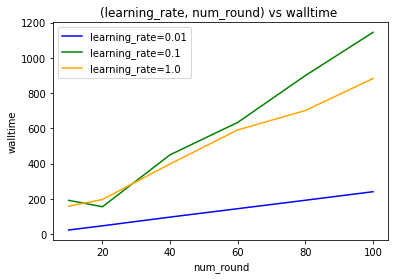

In [89]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'learning_rate', 'num_round', 'walltime'
#ipdb.runcall(
fp.compare_tuning(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

In [90]:
from mpl_toolkits import mplot3d

In [95]:
reload(fp)

<module 'fresh.plot' from '/opt/program/fresh/plot.py'>

ValueError: Argument Z must be 2-dimensional.

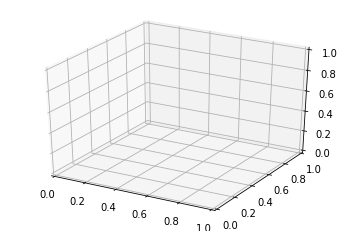

In [96]:
keep_fixed = {
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'subsample': 0.1,
 'num_round': 10,
        }
col1, col2, metric_col = 'learning_rate', 'num_round', 'walltime'
#ipdb.runcall(
fp.compare_two_features_3D(df, feature_col_1=col1, 
             feature_col_2=col2, 
             metric_col=metric_col,
             keep_fixed=fvu.without(
                 keep_fixed, keys=[col1, col2]))

In [98]:
import numpy as np
def z_function(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = z_function(X, Y)

In [103]:
print(X.shape, Y.shape, Z.shape)
x

(30, 30) (30, 30) (30, 30)


array([-6.        , -5.5862069 , -5.17241379, -4.75862069, -4.34482759,
       -3.93103448, -3.51724138, -3.10344828, -2.68965517, -2.27586207,
       -1.86206897, -1.44827586, -1.03448276, -0.62068966, -0.20689655,
        0.20689655,  0.62068966,  1.03448276,  1.44827586,  1.86206897,
        2.27586207,  2.68965517,  3.10344828,  3.51724138,  3.93103448,
        4.34482759,  4.75862069,  5.17241379,  5.5862069 ,  6.        ])